# COMP642 -- Project

- Student: Christof Dittmar
- ID: cd77

## Scratchpad

The scratchpad shows the full implementation for one CNN architecture including

- reading the data
- preprocessing
- splitting
- model setup
- training & plot of training history
- prediction
- manual test

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import version as tf_version

print('tensorflow version', tf_version.VERSION)

tensorflow version 2.16.2


#### Reading image dataset

In [2]:
from pathlib import Path
from config import OUTPUT_DIR
from config import Overlay

overlay = Overlay()
class_names = [g.subject_type for g in overlay.groups]
img_width = overlay.output_image_width
data = image_dataset_from_directory(OUTPUT_DIR, 
                                    class_names=class_names, 
                                    image_size=(img_width, img_width),
                                    shuffle=True)

Found 1000 files belonging to 2 classes.


View some data properties

In [3]:
print('number of batches :', len(data))
print('number of classes :', len(data.class_names))
print('classes           :', data.class_names)

number of batches : 32
number of classes : 2
classes           : ['animal', 'human']


#### Define preprocessing by pipeline

In [4]:
data = data.map(lambda x, y: (x/255.0, y))

In [5]:
print('data max', data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min())

data max 1.0 0.0


#### Define split for training, test and validation sets

In [6]:
from config import Training

train_set_size = int(Training.fraction_training_set * len(data))
val_set_size = int(Training.fraction_validation_set * len(data))
test_set_size = len(data) - train_set_size - val_set_size
total_set_size = train_set_size + val_set_size + test_set_size

train_set = data.take(train_set_size)
validation_set = data.skip(train_set_size).take(val_set_size)
test_set = data.skip(train_set_size + val_set_size).take(test_set_size)

print('Set sizes in number of batches')
print('train set size      :', len(train_set))
print('validation set size :', len(validation_set))
print('test set size       :', len(test_set))
print('total set size      :', len(data))

Set sizes in number of batches
train set size      : 19
validation set size : 6
test set size       : 7
total set size      : 32


#### Building the model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets

In [8]:
data.element_spec[0].shape[1:]

TensorShape([244, 244, 3])

In [9]:
model = Sequential(
    [
        Input(shape=data.element_spec[0].shape[1:]),
        Conv2D(32, (3,3), activation='relu', padding='valid'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='valid'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ],
    name='CNN'
)
model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 445568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    28,516,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,609,729 (109.14 MB)

 Trainable params: 28,609,729 (109.14 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Train model

In [11]:
from config import LOG_DIR

tensorboard_callback = TensorBoard(log_dir=LOG_DIR)
history = model.fit(train_set, epochs=20, validation_data=validation_set, callbacks=[tensorboard_callback])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5691 - loss: 1.6203 - val_accuracy: 0.5833 - val_loss: 0.6604
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6365 - loss: 0.5558 - val_accuracy: 0.5885 - val_loss: 0.4249
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7796 - loss: 0.3532 - val_accuracy: 0.9010 - val_loss: 0.3274
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9737 - loss: 0.2794 - val_accuracy: 0.9583 - val_loss: 0.3376
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9901 - loss: 0.2734 - val_accuracy: 0.9948 - val_loss: 0.3283
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9967 - loss: 0.2631 - val_accuracy: 0.9948 - val_loss: 0.3024
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9951 - loss: 0.2613 - val_accuracy: 0.8958 - val_loss: 0.3099
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9967 - loss: 0.2518 - val_accuracy: 0.9583 - val_loss:

#### Plotting history

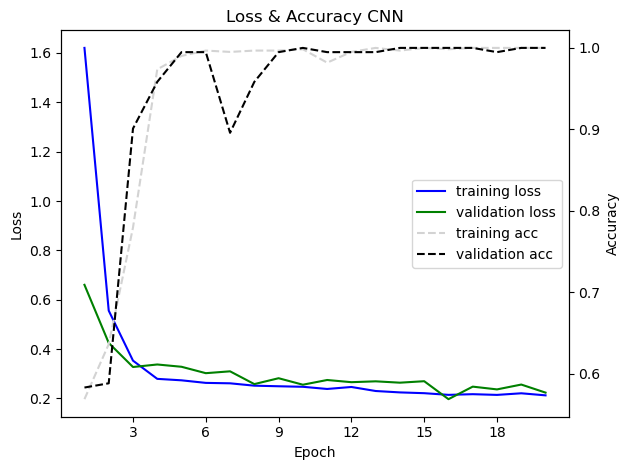

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import numpy as np

def plot(history):
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss & Accuracy {history.model.name.upper()}')
    x = [i + 1 for i in range(len(history.history['loss']))]
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    lines = []
    lines += ax.plot(x, history.history['loss'], 
                     label='training loss', 
                     color='blue')
    lines += ax.plot(x, history.history['val_loss'],   
                     label='validation loss', 
                     color='green')

    ax_ = ax.twinx()
    ax_.xaxis.set_major_locator(MaxNLocator(integer=True))

    lines += ax_.plot(x, history.history['accuracy'], 
                      label='training acc', 
                      color='lightgrey', 
                      linestyle='dashed')
    lines += ax_.plot(x, history.history['val_accuracy'], 
                      label='validation acc', 
                      color='black', 
                      linestyle='dashed')
    ax_.set_ylabel('Accuracy')

    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center right')
    fig.tight_layout()

    plt.show()

plot(history)

#### Predictions

In [13]:
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.math import confusion_matrix

precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [14]:
labels = []
predicted = []
for X, y in test_set.as_numpy_iterator():
    y_ = model.predict(X)
    labels += list(y)
    predicted += list(y_)
    precision.update_state(y, y_)
    recall.update_state(y, y_)
    accuracy.update_state(y, y_)

print(f'precision : {precision.result().numpy()}')
print(f'recall : {recall.result().numpy()}')
print(f'accuracy : {accuracy.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
precision : 1.0
recall : 1.0
accuracy : 1.0


In [15]:
conf_matrix = confusion_matrix(labels, [v > 0.5 for v in predicted])
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 80,   0],
       [  0, 120]], dtype=int32)>

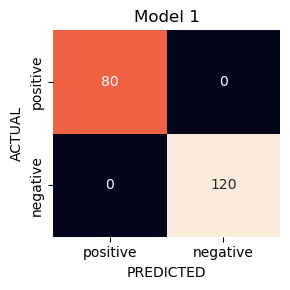

In [16]:
import pandas as pd
import seaborn as sn

def plot_conf_matrix(conf_matrix):
    plot_labels = ['positive', 'negative']
    cm_df = pd.DataFrame(conf_matrix, index=plot_labels, columns=plot_labels)
    plt.figure(figsize = (3, 3))
    plt.title('Model 1')
    sn.heatmap(cm_df, annot=True, fmt='d', cbar=False)
    plt.xlabel('PREDICTED')
    plt.ylabel('ACTUAL')
    plt.tight_layout()

plot_conf_matrix(conf_matrix)

#### Manual Testing

Use images supposedly from a camera. This if for visual inspection.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


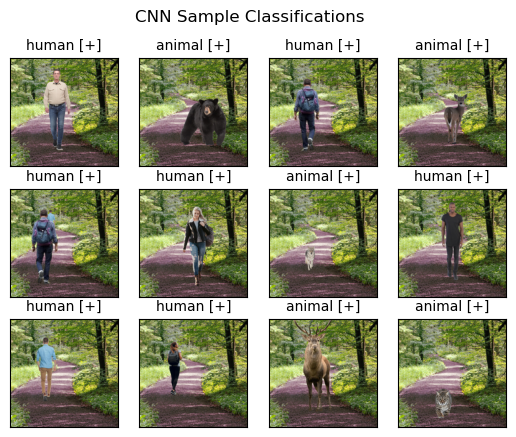

In [25]:
import cv2
from PIL import Image

image_directory = OUTPUT_DIR / 'real'
classes = ['animal', 'human']

grid_row_size = 3
grid_col_size = 4
fig, ax = plt.subplots(grid_row_size, grid_col_size)
fig.suptitle(f'{model.name} Sample Classifications')

for idx, file in enumerate(image_directory.iterdir()):
    if idx >= grid_row_size * grid_col_size:
        break;
    img = Image.open(file)
    y = int(img.info['subject'] == 'human')
    x = np.asarray(img)

    y_ = model.predict(np.expand_dims(x/255.0, 0))
    class_idx = 1 if y_ > 0.5 else 0
    indicator = '[+]' if class_idx == y else '[-]'

    plot_row = idx // grid_col_size
    plot_col = idx % grid_col_size
    ax[plot_row, plot_col].imshow(img)
    ax[plot_row, plot_col].set_title(f'{classes[class_idx]} {indicator}', fontsize=10)
    ax[plot_row, plot_col].xaxis.set_visible(False)
    ax[plot_row, plot_col].yaxis.set_visible(False)

In [39]:
from functools import partial
global model_summary
model_summary = ''
def add_to_summary(collector, line):
    collector += line
write_func = partial(add_to_summary, model_summary)
write_func('test')
write_func('more')
print(model_summary)